## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression

## Importing Dataset

In [ ]:
data = pd.read_csv("train.csv")
data.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


## Preprocessing Dataset

### Step 1: Handling missing values ('?') in "ethnicity" and "relation"

In [ ]:
print("ethnicity distribution")
print("----------------------")
print(data["ethnicity"].value_counts())

ethnicity distribution
----------------------
ethnicity
White-European     257
?                  203
Middle Eastern      97
Asian               67
Black               47
South Asian         34
Pasifika            32
Others              29
Latino              17
Hispanic             9
Turkish              5
others               3
Name: count, dtype: int64


In [ ]:
print("relation distribution")
print("----------------------")
print(data["relation"].value_counts())

relation distribution
----------------------
relation
Self                        709
?                            40
Parent                       29
Relative                     18
Others                        2
Health care professional      2
Name: count, dtype: int64


In [ ]:
# Calculate the percentage of missing values ('?') in ethnicity and relation
total_rows = len(data)
missing_ethnicity = (data["ethnicity"] == "?").sum()
missing_relation = (data["relation"] == "?").sum()
print(f"Number of '?' in ethnicity: {(missing_ethnicity / total_rows) * 100:.2f} %")
print(f"Number of '?' in relation: {(missing_relation / total_rows) * 100:.2f} %")

Number of '?' in ethnicity: 25.37 %
Number of '?' in relation: 5.00 %


25% missing in ethnicity is significant, so deletion is not reasonable to avoid losing data.
Replacing '?' with 'Unknown' preserves information without biasing the dataset.

In [ ]:
data["ethnicity"] = data["ethnicity"].replace("?", "Unknown")

5% missing is relatively low, and 'Self' is the most frequent category (mode). Replacing '?' with the mode ('Self') is reasonable to maintain data distribution.

In [ ]:
data["relation"] = data["relation"].replace("?", "Self")

In [ ]:
print("\nAfter handling missing values:")
print("Number of '?' in ethnicity:", (data['ethnicity'] == '?').sum())
print("Number of '?' in relation:", (data['relation'] == '?').sum())


After handling missing values:
Number of '?' in ethnicity: 0
Number of '?' in relation: 0


### Step 2: Handling negative values in "result"

Negative values are invalid since result should be the sum of A1_Score to A10_Score (0 to 10)

In [ ]:
negative_results = data[data["result"] < 0]["result"]
print(f"Number of negative result values: {len(negative_results)}")

Number of negative result values: 49


In [ ]:
data['result_calculated'] = data[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score',
                             'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']].sum(axis=1)

In [ ]:
data["result"] = np.where(data["result"] < 0, data['result_calculated'], data["result"])

In [ ]:
data.drop("result_calculated", axis=1, inplace=True)

In [ ]:
print("\nAfter handling negative results:")
print("Number of negative result values:", (data['result'] < 0).sum())


After handling negative results:
Number of negative result values: 0


### Step 3: Encoding Text Features

"gender", "jaundice", "autism", and "used_app_before" are binary (2 categories).
Label Encoding (0/1) is simple and sufficient for binary features

In [ ]:
# Fixed a typo in the column name
data.rename(columns={"austim": "autism"}, inplace=True)

In [ ]:
data["gender"] = data["gender"].map({"m": 0, "f": 1})
data["jaundice"] = data["jaundice"].map({"no": 0, "yes": 1})
data["autism"] = data["autism"].map({"no": 0, "yes": 1})
data["used_app_before"] = data["used_app_before"].map({"no": 0, "yes": 1})

"ethnicity" has 11 categories; Target Encoding captures relationship with Class/ASD

In [ ]:
ethnicity_target = data.groupby("ethnicity")["Class/ASD"].mean()
data["ethnicity"] = data["ethnicity"].map(ethnicity_target)
print("\nTarget Encoding for ethnicity:\n", ethnicity_target)


Target Encoding for ethnicity:
 ethnicity
Asian              0.059701
Black              0.127660
Hispanic           0.222222
Latino             0.235294
Middle Eastern     0.061856
Others             0.068966
Pasifika           0.187500
South Asian        0.088235
Turkish            0.000000
Unknown            0.034483
White-European     0.470817
others             0.000000
Name: Class/ASD, dtype: float64


"country_of_res" has 50+ categories, which is too many for One-Hot Encoding.
Reduce to top 10 countries + 'Other' to avoid high dimensionality

In [ ]:
# Fixed a typo in the column name
data.rename(columns={"contry_of_res": "country_of_res"}, inplace=True)

In [ ]:
top_countries = data["country_of_res"].value_counts().index[:10]
data["country_of_res"] = data["country_of_res"].apply(lambda x: x if x in top_countries else "Other")
data = pd.get_dummies(data, columns=["country_of_res"], prefix="country", drop_first=True)
print("\nNew columns after One-Hot Encoding for contry_of_res:",
      [col for col in data.columns if col.startswith('country_')])


New columns after One-Hot Encoding for contry_of_res: ['country_Australia', 'country_Canada', 'country_India', 'country_Jordan', 'country_Netherlands', 'country_New Zealand', 'country_Other', 'country_United Arab Emirates', 'country_United Kingdom', 'country_United States']


"relation" has 5 categories; Target Encoding is used to capture relationship with Class/ASD

In [ ]:
relation_target = data.groupby("relation")["Class/ASD"].mean()
data["relation"] = data["relation"].map(relation_target)
print("\nTarget Encoding for relation:\n", relation_target)


Target Encoding for relation:
 relation
Health care professional    0.500000
Others                      0.000000
Parent                      0.275862
Relative                    0.222222
Self                        0.197597
Name: Class/ASD, dtype: float64


### Step 4: Drop unnecessary features

age_desc has only one value ("18 and more") and no predictive value and ID is a unique identifier with no predictive value

In [ ]:
data = data.drop(columns=['ID', 'age_desc'], axis=1)

### Step 5: Feature Scaling

age and result are continuous and have different scales, requiring standardization

In [ ]:
scaler = StandardScaler()
data[["age", "result"]] = scaler.fit_transform(data[["age", "result"]])

In [ ]:
data[["age", "result"]]

,age,result
0,0.596329,-0.565692
1,1.183895,-1.510476
2,-1.292684,1.395003
3,-0.299998,-1.505533
4,0.905091,-2.030660
...,...,...
795,-0.727262,0.967822
796,-0.475384,1.097458
797,-1.395065,-1.418675
798,-0.738481,0.061286


## Separate features (X) and target (y)

These features were chosen based on Random Forest feature importance (>0.01). from previous experiments with SMOTE to reduce noise and improve model performance.

In [ ]:
important_features = [
    'ethnicity', 'result', 'A4_Score', 'age', 'A6_Score', 'A9_Score', 'A3_Score',
    'A5_Score', 'A7_Score', 'country_United States', 'relation', 'A10_Score',
    'A8_Score', 'gender', 'A1_Score', 'autism', 'country_Other', 'A2_Score',
    'jaundice', 'country_United Kingdom', 'country_Australia'
]

X = data[important_features]
y = data['Class/ASD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])
print("\nClass distribution (relative):")
print(y.value_counts(normalize=True))

Number of samples: 800
Number of features: 21

Class distribution (relative):
Class/ASD
0    0.79875
1    0.20125
Name: proportion, dtype: float64


## Evaluating the Logistic Regression model

In [ ]:
model = LogisticRegression(class_weight="balanced", random_state=42)

print("Evaluating Logistic Regression with Class Weight...")
score = cross_validate(model, X_train, y_train, cv=10, scoring="f1_macro")

print("Mean CV f1-score:", score['test_score'].mean())

Evaluating Logistic Regression with Class Weight...
Mean CV f1-score: 0.7787879469607506


## Training the Logistic Regression model

In [ ]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

## Evaluating the final model with Confusion Matrix

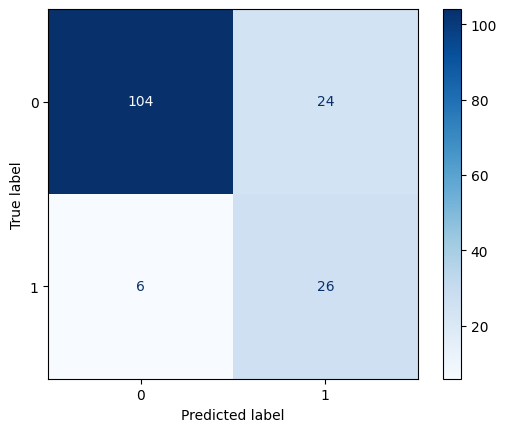

In [ ]:
cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap='Blues')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87       128
           1       0.52      0.81      0.63        32

    accuracy                           0.81       160
   macro avg       0.73      0.81      0.75       160
weighted avg       0.86      0.81      0.83       160

